# Gradual Reduction in US Food Insecurity (2010-2015)

### Introduction
The motivation behind this project was to expand my toolkit of statistical techniques. Additionally, I wanted to complete a robust analysis of a dataset without using a machine learning model. I think I achieved both goals and am quite satisfied with the results.

### Data
The data comes from the United States Department of Agriculture (USDA) Economic Research Service's (ERS) Food Environmental Atlas. Because the comes from a reliable source I can put significant faith in the results of the report. The dataset has over 275 variables and offers an eclectic overview of the US population's relationship with food sources. The dataset has a diverse set of variables, ranging from the sales tax on soda to the number of berry farms. This allows me to test a variety of hypotheses and use a variety of visualization and statistical techniques to test them.

### Questions
The main thing I'll be looking at is the percent of households experiencing food insecurity. The USDA uses the following definition of food insecurity: 
> Food insecurity is the limited or uncertain availability of nutritionally adequate and safe foods or limited or uncertain ability to acquire acceptable foods in socially acceptable ways.

Main questions:
- Has the level of food insecurity changed?
- What are the factors correlated with food insecurity?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

#Runs functions that build datasets and create linear regression models
%run helper.py

In [2]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9, 9))
sns.set_style('darkgrid')

In [3]:
health = pd.read_csv('../data/interim/health.csv')
insecurity = pd.read_csv('../data/interim/insecurity.csv')
price = pd.read_csv('../data/interim/price_taxes.csv')
regression_long = pd.read_csv('../data/processed/regression_long.csv')
regression_short = pd.read_csv('../data/processed/regression_short.csv')
stores = pd.read_csv('../data/interim/stores.csv')
supp_county = pd.read_csv('../data/interim/supp_county.csv')

# EDA

Because the dataset only has food insecurity at the state level I had to group most of the datasets by states. 

Population data is always a good place to start, so I'll examine the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.

Text(0.5, 1.0, 'US Population Change (2010-2016)')

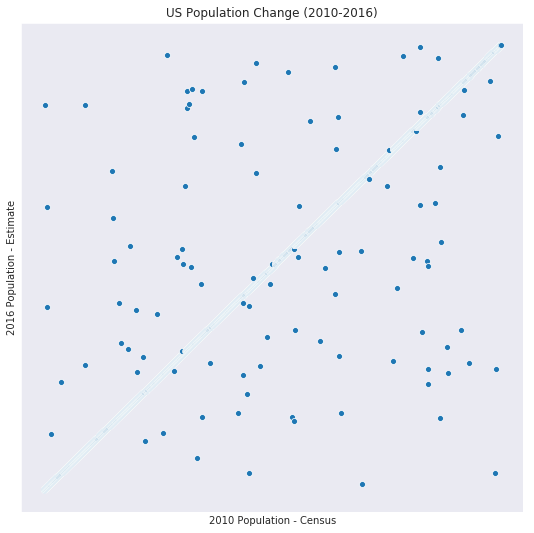

In [8]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])
plt.xlabel('2010 Population - Census')
plt.ylabel('2016 Population - Estimate')
plt.title('US Population Change (2010-2016)')

Below we have a scatterplot of the change percent change in food insecurity from 2010 to 2015. 17 states including the District of Columbia saw a increase in food insecurity, 2 states saw no change and 31 states had a decrease in food insecurity.

/home/ckc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


([], <a list of 0 Text xticklabel objects>)

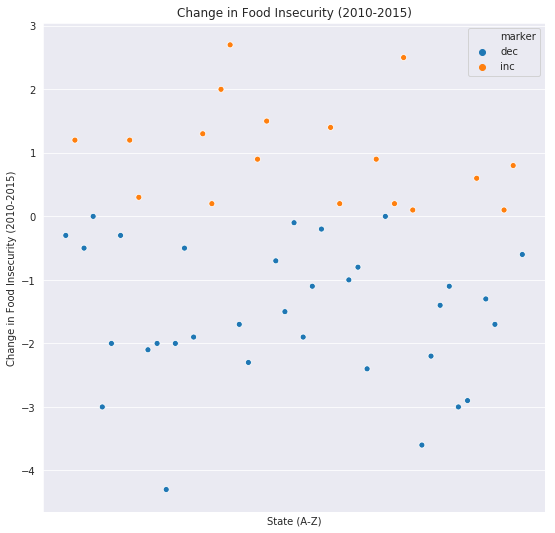

In [10]:
insecurity_state = insecurity.groupby(['State']).head(1)

insecurity_state['marker'] = np.where(insecurity_state['CH_FOODINSEC_12_15'] > 0, 'inc', 'dec')
sns.scatterplot(x='State', y='CH_FOODINSEC_12_15', hue = 'marker', data=insecurity_state)
plt.xlabel('State (A-Z)')
plt.ylabel('Change in Food Insecurity (2010-2015)')
plt.title('Change in Food Insecurity (2010-2015)')
plt.xticks([])

In [11]:
imprv_smallest = insecurity_state.loc[insecurity_state['CH_FOODINSEC_12_15'].idxmax()]
imprv_largest = insecurity_state.loc[insecurity_state['CH_FOODINSEC_12_15'].idxmin()]

message = (
    f"During 2010 to 2015 {imprv_largest['State']} saw the largest reduction in food insecurity, with a "
    f"{imprv_largest['CH_FOODINSEC_12_15']}% decrease statewide. Meanwhile, {imprv_smallest['State']} performed "
    f"the worst, increasing food insecurity by {imprv_smallest['CH_FOODINSEC_12_15']}%."
)
           
message

'During 2010 to 2015 HI saw the largest reduction in food insecurity, with a -4.3% decrease statewide. Meanwhile, LA performed the worst, increasing food insecurity by 2.7%.'

# Statistical Tests

In order to determine which test are appropriate I need to test if the distributions are Gaussian. The function test_normality, located in helper.py, I wrote performs both a Shapiro-Wilk test and D’Agostino’s $K^2$ test for normality as well as graphing the density. Multiple normality tests helps me be sure of the result.

Because both of the state_FOODINSEC_10_12 and state_FOODINSEC_13_15 are normally distributed I can use statistical techniques that assume normality.

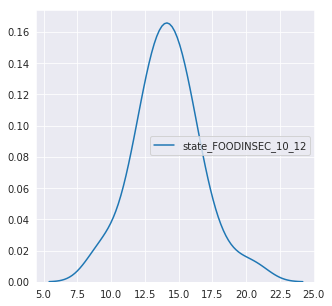

Sharpio-Wilk Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed


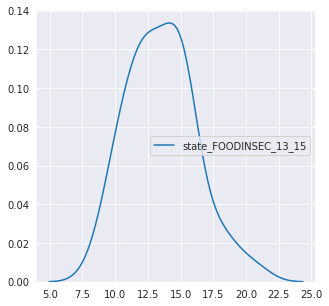

Sharpio-Wilk Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed


In [44]:
test_normality(regression_short, 'state_FOODINSEC_10_12')
test_normality(regression_short, 'state_FOODINSEC_13_15')

Because I am comparing the states, plus DC, at two different time points a paired t-test can be used. The paired t-test examines if the mean changes, with a $H_0$ that the no change occurred. For all the statistical test I run the critical value will be set at 0.05. Because the p-value of the paired t-test is (much) less than the critical value, I can say that the food insecurity did change between 10-12 and 13-15. That is, the difference in means of 0.6333 is significant. As a country the United States has decreased food insecurity, hooray.

In [14]:
stats.ttest_rel(regression_short['state_FOODINSEC_10_12'],
                regression_short['state_FOODINSEC_13_15'])

Ttest_relResult(statistic=2.878865632380211, pvalue=0.005858791185468704)

The Levene's test test if variance between two or more groups. Unlike the paired t-test, the Levene's test does not assume normality. With a p-value greater than the critical value, the $H_0$ that variance is the same is not rejected. The results implies that the inequalities among states remains.

In [15]:
stats.levene(regression_short['state_FOODINSEC_10_12'],
             regression_short['state_FOODINSEC_13_15'], center='mean')

LeveneResult(statistic=0.803041136388057, pvalue=0.37233781698797197)

# Regression

Two linear regression models were created:
- regression_short: Uses 5 hand picked features trying to predict state_FOODINSEC_13_15. Features were selected based off of correlation plots and intution. 
- regression_long: Uses 20 hand picked features which were subjected to ridge regularization.

The results of the regression are somewhat suprising to me. Having hand picked these 5 features out of [x] I thought the coefficients would be more evenly distributed among them. Instead, we see that FOODINSEC_10_12 is by far the strong predictor of FOODINSEC_13_15. This is not suprising with only a 6 year span I wouldn't expect states to adapt that fast.

In [10]:
feat = list(regression_short.iloc[:,2:])
target = 'state_FOODINSEC_13_15'

lm, rs, mse = create_lm(regression_short, feat, target)

Model Validation 
R^2 =  0.7744062579860689 
Mean squared error =  0.00864586908084325


In [19]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(regression_short[feat])
est = sm.OLS(regression_short[target], X2)
est2 = est.fit()
print(est2.summary())

ModuleNotFoundError: No module named 'statsmodels'

In [11]:
pd.DataFrame(list(zip(feat, lm.coef_.T)), columns=['feature', 'estimated_coefficient'])

,feature,estimated_coefficient
0,state_FOODINSEC_10_12,[0.7908010423901574]
1,state_LACCESS_POP15,[3.589490832376085e-06]
2,state_LACCESS_LOWI15,[-6.163455191165104e-05]
3,state_MEDHHINC15,[-5.039341409815082e-05]
4,state_GROCPTH14,[-0.18974914707209342]


# Conclusion

America has lowered food insecurity nationwide by 0.6333 percent. In the span of 5 years I'd say that's a pretty good improvement, we're heading in the right direction. However, we still have a long way to go. Nevada, the state that has the lowest food insecurity percentage, still has a food insecurity at 8.5% in 2013-2015. That means even in our best performing  state nearly 1 in 10 people in America experience food insecurity. That is a extremely troubling number. Especially when considering the other side of the spectrum  with Missouri at 20.8%. The socioeconomic drivers of this discrepancy needs to be explored in further analysis in order to eliminate the root causes of food insecurity.

### Personal Takeaway
I was also quite proud of the linear regression I ran. I thought it was going to a be a quick and dirty add-on but I ended up with a robust regression. I did a lot more work than I had previously done testing the features before modelling and verifying the results of the regression afterwards. 

Ultimately I think the most useful statistical measurement I completed was the min-max of food insecurity. Not a more sophisticated statistical test or a nice regression. To me this shows that numbers themselves tell the story, we just use tools to guide the story along.

In [8]:
insecurity_state.loc[insecurity_state['FOODINSEC_13_15'].idxmin()]

FIPS                         32001
State                           NV
County                   Churchill
FOODINSEC_10_12                8.7
FOODINSEC_13_15                8.5
CH_FOODINSEC_12_15            -0.2
VLFOODSEC_10_12                3.4
VLFOODSEC_13_15                2.9
CH_VLFOODSEC_12_15            -0.5
FOODINSEC_CHILD_01_07          8.6
FOODINSEC_CHILD_03_11          9.5
marker                         dec
Name: 1747, dtype: object